In [ ]:

import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Transfer 'jpg' images to an array IMG

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train = []
benign_test = []
malign_train = []
malign_test = []

benign_train= np.array(Dataset_loader('Images_Path',224))
benign_test = np.array(Dataset_loader('Images_Path',224))
malign_train= np.array(Dataset_loader('Images_Path',224))
malign_test = np.array(Dataset_loader('Images_Path',224))

100%|██████████| 418/418 [00:08<00:00, 46.94it/s]


In [ ]:
benign_train = np.array(benign_train)
benign_test = np.array(benign_test)
malign_train = np.array(malign_train)
malign_test = np.array(malign_test)

In [ ]:
print(benign_train.shape)
print(benign_test.shape)
print(malign_train.shape)
print(malign_test.shape)

(1472, 224, 224, 3)
(1008, 224, 224, 3)
(3536, 224, 224, 3)
(1896, 224, 224, 3)


In [ ]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
# s = np.arange(X_train.shape[0])
# np.random.shuffle(s)
# X_train = X_train[s]
# Y_train = Y_train[s]

# # Shuffle test data
# s = np.arange(X_test.shape[0])
# np.random.shuffle(s)
# X_test = X_test[s]
# Y_test = Y_test[s]

# To categorical
# Y_train = to_categorical(Y_train, num_classes= 2)
# Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5008, 224, 224, 3)
(5008,)
(2904, 224, 224, 3)
(2904,)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.25,
    random_state=11
)

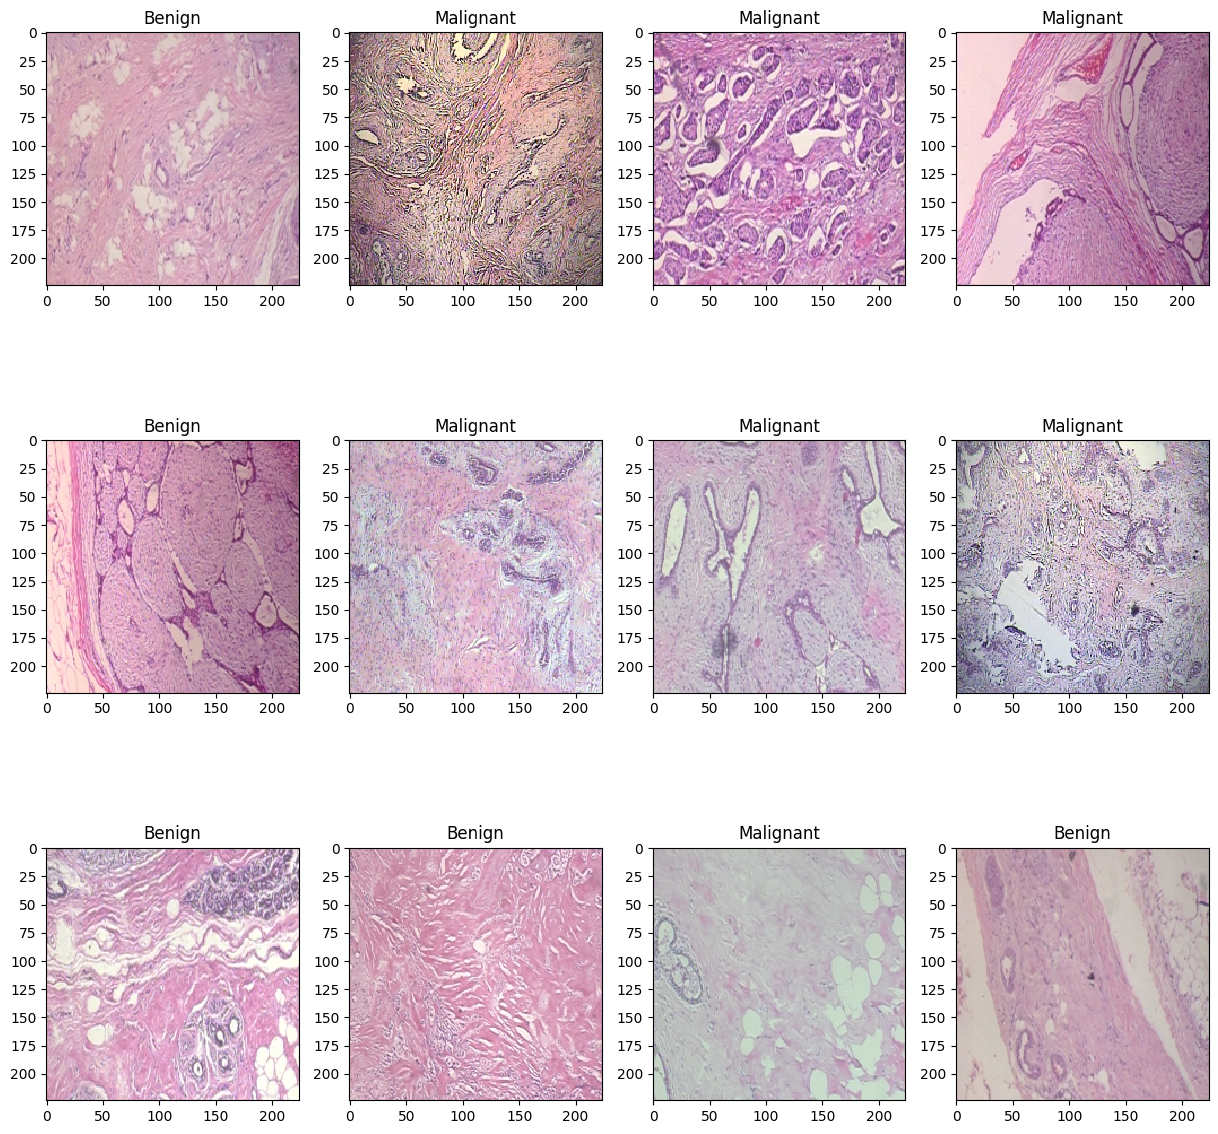

In [ ]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
#Can Use any batch size as per your output accuracy

# BATCH_SIZE = 16
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)





model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18331585 (69.93 MB)
Trainable params: 1809

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

import keras
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

# New Section

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control,checkpoint,early_stopping]
)

<ipython-input-14-15fc531861f7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
118/117 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8203
Epoch 1: val_accuracy improved from -inf to 0.76518, saving model to weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/117 [==============================] - 247s 913ms/step - loss: 0.4299 - accuracy: 0.8203 - val_loss: 0.5152 - val_accuracy: 0.7652 - lr: 1.0000e-04
Epoch 2/30
118/117 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9065
Epoch 2: val_accuracy improved from 0.76518 to 0.90335, saving model to weights.best.hdf5
117/117 [==============================] - 89s 734ms/step - loss: 0.2733 - accuracy: 0.9065 - val_loss: 0.2426 - val_accuracy: 0.9034 - lr: 1.0000e-04
Epoch 3/30
118/117 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9143
Epoch 3: val_accuracy improved from 0.90335 to 0.95288, saving model to weights.best.hdf5
117/117 [==============================] - 89s 756ms/step - loss: 0.2322 - accuracy: 0.9143 - val_loss: 0.1347 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 4/30
118/117 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9228
Epoch 4: val_accuracy did not improve from 0.95288
117/117 [==================

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<Axes: >

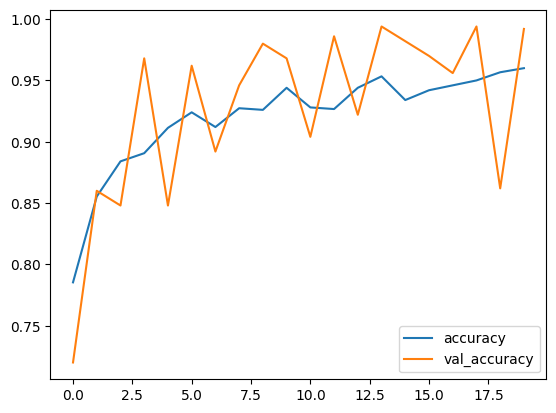

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

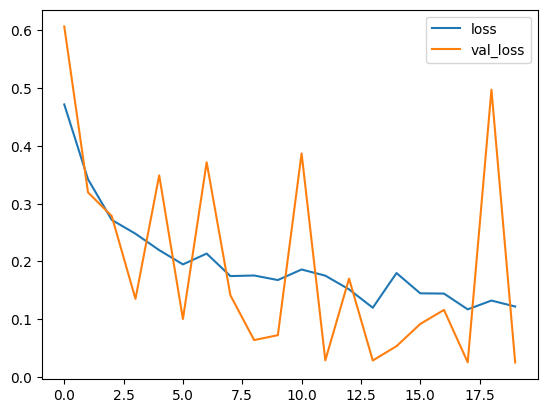

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.load_weights("/content/weights.best.hdf5")

In [ ]:
img = cv2.imread("Test_Image_Path")
img = cv2.resize(img,(224,224))
img = np.expand_dims(img,axis=0)
predictions = model.predict(img)
print(predictions)

1/1 [==============================] - 6s 6s/step
[[0.99315107]]


In [ ]:
Y_val_pred = model.predict(x_val)

4/4 [==============================] - 1s 155ms/step


In [ ]:
y = np.argmax(Y_val_pred,axis=1)

In [ ]:
accuracy_score(np.argmax(y_val, axis=0), np.argmax(Y_val_pred, axis=0))

InvalidParameterError: The 'y_true' parameter of accuracy_score must be an array-like or a sparse matrix. Got 0 instead.

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
# from sklearn.metrics import accuracy_score

# # Assuming model.predict(x_val) returns probabilities
# y_pred_proba = model.predict(x_val)

# # Convert probabilities to binary predictions using a threshold (e.g., 0.5)
# y_pred_binary = (y_pred_proba > 0.5).astype(int)

# # Calculate accuracy
# accuracy = accuracy_score(y_val, y_pred_binary)
# print(accuracy)
from sklearn.metrics import accuracy_score

# Assuming Y_pred contains class probabilities and you want to convert them to class labels
Y_pred_labels = np.argmax(Y_pred)
Y_test_labels = np.argmax(Y_test)
y_pred_binary = (Y_pred_labels > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(Y_test_labels, y_pred_binary)

print(f"Accuracy: {accuracy:.2%}")


NameError: name 'Y_pred' is not defined

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 33s 239ms/step


 10%|█         | 1/10 [00:36<05:25, 36.15s/it]

125/125 [==============================] - 30s 243ms/step


 20%|██        | 2/10 [01:08<04:31, 33.94s/it]

125/125 [==============================] - 29s 228ms/step


 30%|███       | 3/10 [01:53<04:32, 38.92s/it]

Confusion matrix, without normalization
[[190  60]
 [  1 249]]


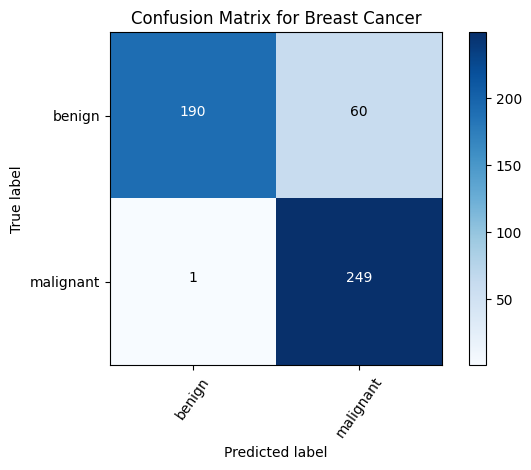

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_pred_binary = (Y_pred > 0.5).astype(int)
cm = confusion_matrix(Y_test, y_pred_binary)

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[203  52]
 [ 28 462]]


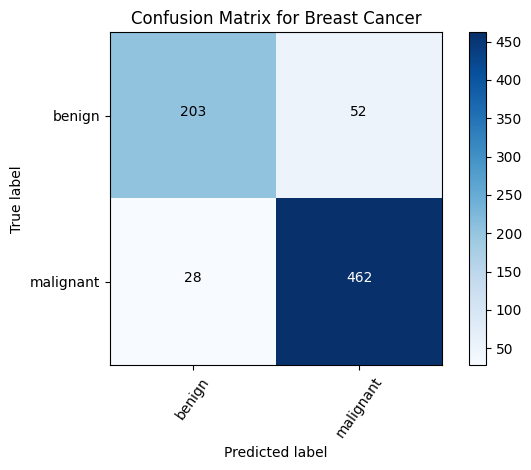

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

In [ ]:
from sklearn.metrics import classification_report
y_pred_binary = (Y_pred > 0.5).astype(int)
cm = confusion_matrix(Y_test, y_pred_binary)
report = classification_report( Y_test, y_pred_binary,output_dict=True)

report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision  recall  f1-score  support
0.0            0.994764   0.760  0.861678  250.000
1.0            0.805825   0.996  0.890877  250.000
accuracy       0.878000   0.878  0.878000    0.878
macro avg      0.900295   0.878  0.876277  500.000
weighted avg   0.900295   0.878  0.876277  500.000


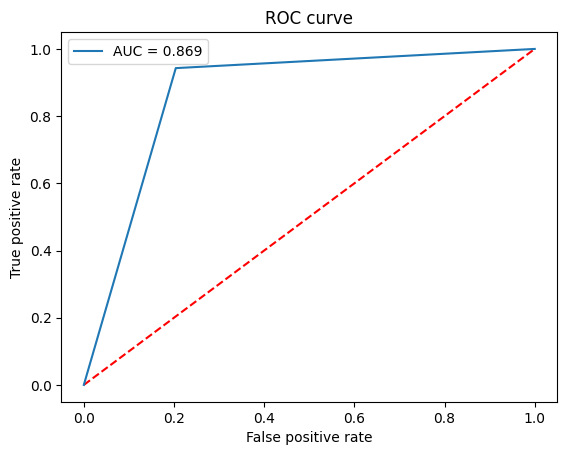

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()